# Detection Of Military Aircraft Types With Satellite Photos 

### Gerekli kütüphaneleri yükleme

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os


### Eğitim ve test verilerinin dizin yolları

In [28]:
train_files_path = "airplanedataset/Train/"
test_files_path = "airplanedataset/Test/"

### Test fotoğrafını yükleme ve görüntüleme

(400, 400, 3)


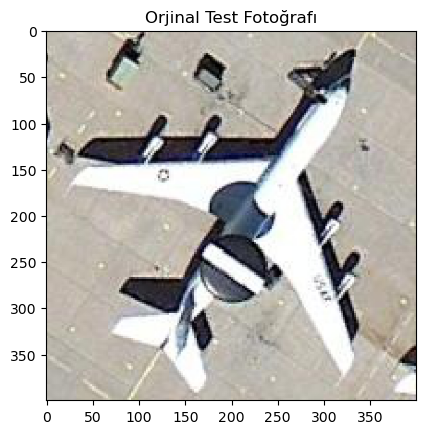

In [29]:
img_path = test_files_path + "E-3/9-18.jpg"
img = load_img(img_path, target_size=(400, 400))
print(img_to_array(img).shape)
plt.imshow(img)
plt.title("Orjinal Test Fotoğrafı")
plt.show()

### Veri artırma işlemi ile veri setini oluşturma

In [30]:
train_data = ImageDataGenerator().flow_from_directory(train_files_path, target_size=(400, 400))
test_data = ImageDataGenerator().flow_from_directory(test_files_path, target_size=(400, 400))

Found 770 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


### Transfer öğrenme için ResNet50 modeli

In [33]:
base_model = ResNet50(weights='imagenet', include_top=False)

### Modeli oluşturma

In [34]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(train_data.class_indices), activation='softmax'))


### Modeli dondurulan katmanlara kadar dondurma

In [35]:
for layer in base_model.layers:
    layer.trainable = False

### Modeli derleme

In [36]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


### Modeli eğitme

In [37]:
batch_size = 4
epochs = 5

### Eğitim sürecini kaydetmek için history kullanma

In [38]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=epochs,
                    validation_data=test_data,
                    validation_steps=len(test_data))


Epoch 1/5
25/25 [==============================] - 221s 9s/step - loss: 0.7426 - accuracy: 0.7130 - val_loss: 0.2764 - val_accuracy: 0.9300
Epoch 2/5
25/25 [==============================] - 238s 10s/step - loss: 0.0833 - accuracy: 0.9831 - val_loss: 0.1960 - val_accuracy: 0.9300
Epoch 3/5
25/25 [==============================] - 236s 9s/step - loss: 0.0302 - accuracy: 0.9948 - val_loss: 0.1496 - val_accuracy: 0.9700
Epoch 4/5
25/25 [==============================] - 261s 10s/step - loss: 0.0175 - accuracy: 0.9987 - val_loss: 0.1889 - val_accuracy: 0.9700
Epoch 5/5
25/25 [==============================] - 275s 11s/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.1486 - val_accuracy: 0.9700


### Doğruluk grafiği

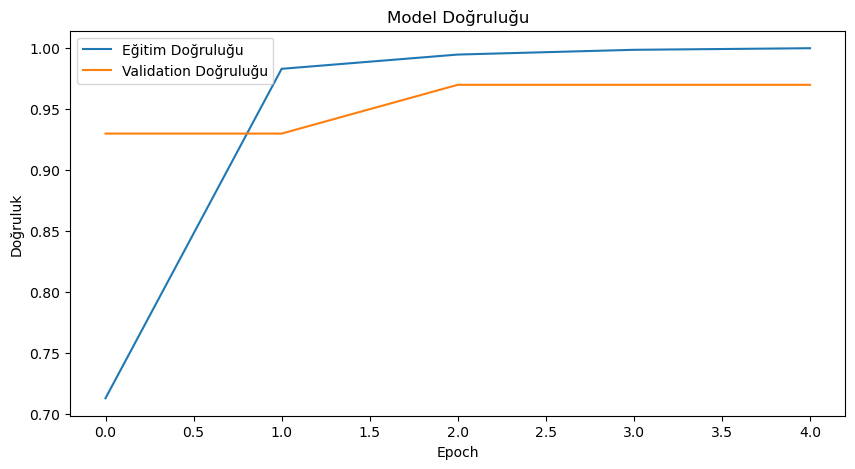

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Validation Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()

### Kayıp grafiği

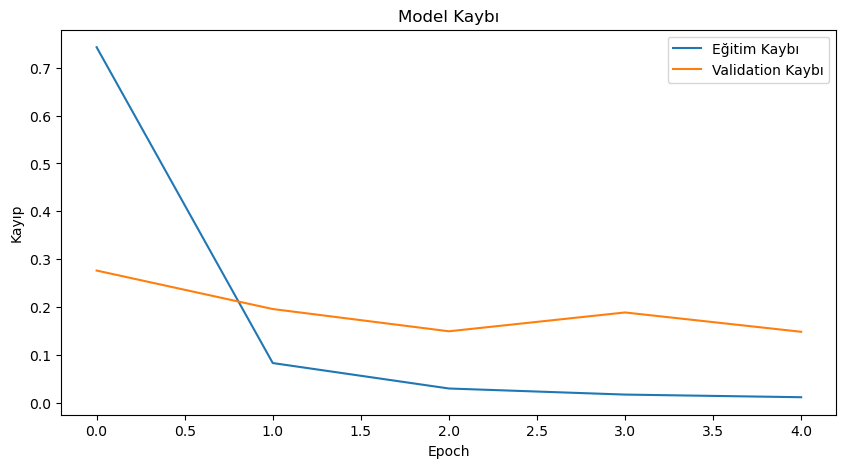

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Validation Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

### 3 ayrı rastgele test resmi seçme ve gerçek sınıflarını alma

In [43]:
test_generator = test_data
test_generator.reset()

### Görüntüleme

1/1 [==============================] - 0s 206ms/step


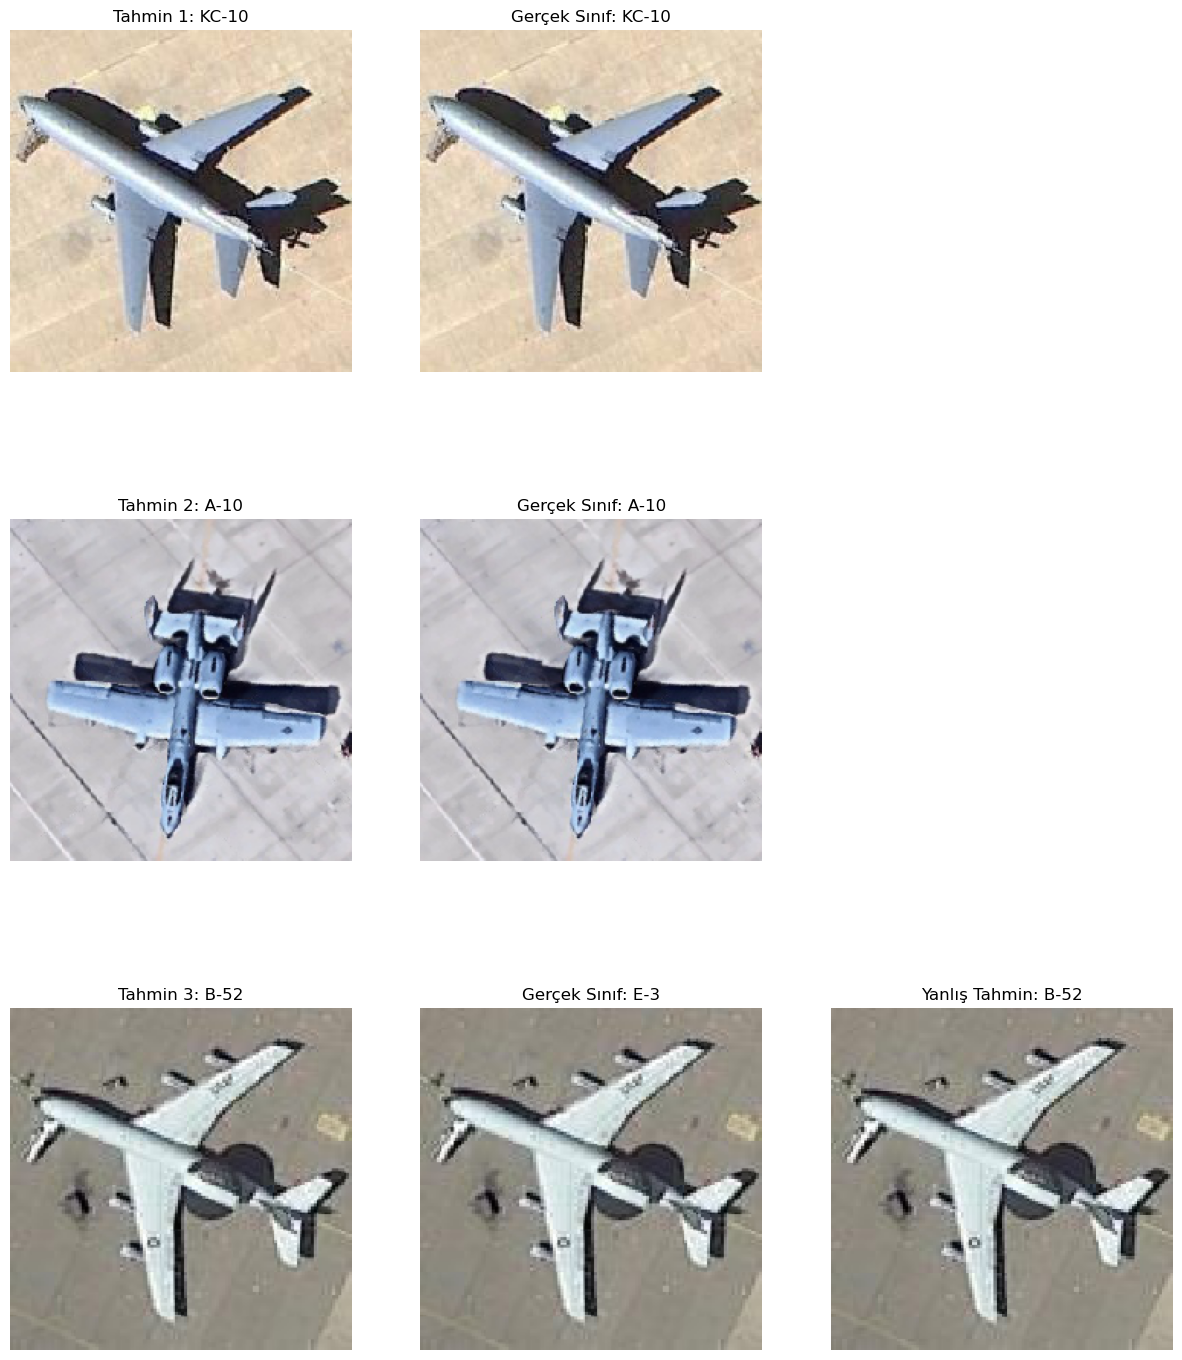

In [185]:
plt.figure(figsize=(15, 18))

for i in range(3):
    # Rastgele bir resmi seçmek için
    random_index = np.random.randint(0, len(test_generator.filenames))
    img_path = os.path.join(test_files_path, test_generator.filenames[random_index])
    img = load_img(img_path, target_size=(224, 224))

    actual_class = os.path.dirname(test_generator.filenames[random_index])

    # Tahmin etme
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    top_class_idx = np.argmax(preds)
    top_class = list(train_data.class_indices.keys())[top_class_idx]

    # Tahmin edilen resmin orjinal hali
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(img)
    plt.title("Tahmin {}: {}".format(i + 1, top_class))
    plt.axis('off')

    # Gerçek sınıfın resmi
    actual_img_path = os.path.join(test_files_path, test_generator.filenames[random_index])
    actual_img = load_img(actual_img_path, target_size=(224, 224))
    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(actual_img)
    plt.title("Gerçek Sınıf: {}".format(actual_class))
    plt.axis('off')

    # Eğer tahmin farklı ise yanlış tahminin resmini gösterme
    if top_class != actual_class:
        wrong_img_path = os.path.join(test_files_path, test_generator.filenames[random_index])
        wrong_img = load_img(wrong_img_path, target_size=(400, 400))
        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(wrong_img)
        plt.title("Yanlış Tahmin: {}".format(top_class))
        plt.axis('off')
        
plt.show()

### Confusion Matrix

4/4 [==============================] - 25s 5s/step


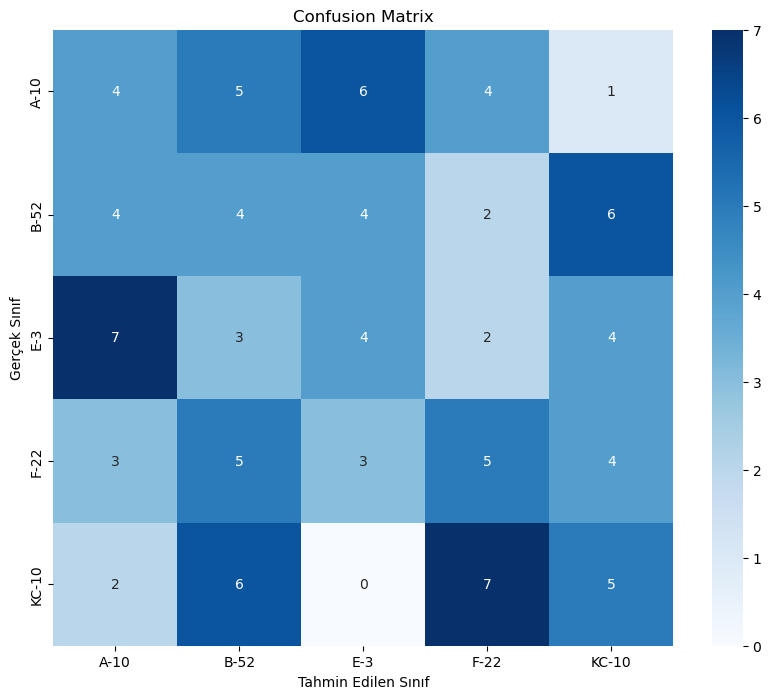

In [186]:
y_pred = model.predict(test_data, steps=len(test_data))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(test_data.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.show()

### Sınıf bazında performans raporu

In [187]:
print(classification_report(y_true, y_pred_classes, target_names=class_names))


              precision    recall  f1-score   support

        A-10       0.20      0.20      0.20        20
        B-52       0.17      0.20      0.19        20
         E-3       0.24      0.20      0.22        20
        F-22       0.25      0.25      0.25        20
       KC-10       0.25      0.25      0.25        20

    accuracy                           0.22       100
   macro avg       0.22      0.22      0.22       100
weighted avg       0.22      0.22      0.22       100

